In [12]:
import plotly
import matplotlib.pyplot as plt
import uproot3 as uproot
import numpy as np

In [ ]:
inline void TLorentzVector::SetPtEtaPhiM(Double_t pt, Double_t eta, Double_t phi, Double_t m) {
   pt = TMath::Abs(pt);
   SetXYZM(pt*TMath::Cos(phi), pt*TMath::Sin(phi), pt*sinh(eta) ,m);

In [ ]:
def set_pt_eta_phi_m(pt, eta, phi, m):
    '''
    
    '''
    pt = np.abs(pt)
    

In [9]:
# ntup = '/home/sys-ad/Desktop/phys165/hgcalNtuple_1000_1.root'
# event = uptools.get_event_rootfile(ntup, 100)
# event['gunparticle_id']

In [13]:
ntuple = uproot.open('hgcalNtuple_1000_1.root')
tree = ntuple['ana/hgc']
tree.show()

event                      (no streamer)              asdtype('>u8')
lumi                       (no streamer)              asdtype('>u4')
run                        (no streamer)              asdtype('>u4')
vtx_x                      (no streamer)              asdtype('>f4')
vtx_y                      (no streamer)              asdtype('>f4')
vtx_z                      (no streamer)              asdtype('>f4')
genpart_eta                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_phi                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_pt                 TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_energy             TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_dvx                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_dvy                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpart_dvz                TStreamerSTL               asjagged(asdtype('>f4'), 10)
genpa

In [14]:
tree['genpart_eta'].array()

<JaggedArray [[2.1683466 -2.1683466 -2.1683533 ... 2.168718 2.1688957 2.1646702] [1.597272 -1.597272 -1.5972618 ... 1.5934938 1.6051322 1.6037395] [1.9971004 -1.9971004 -1.9970995 ... 1.9971778 1.9985602 1.9900777] ... [1.6771559 -1.6771559 -1.6771555 ... 1.6771975 1.6771762 1.6770507] [2.3329892 -2.3329892 -2.3329709 ... 2.3324435 2.3511488 2.5218449] [1.8716898 -1.8716898 -1.8716867 ... 1.8721628 1.872446 1.8734807]] at 0x7f2c1d823dc0>

(array([4.3743e+04, 3.7000e+01, 1.6000e+01, 9.0000e+00, 9.0000e+00,
        4.0000e+00, 4.0000e+00, 2.0000e+00, 1.0000e+00, 6.0000e+00]),
 array([3.8332194e-03, 4.1692381e+00, 8.3346434e+00, 1.2500048e+01,
        1.6665453e+01, 2.0830858e+01, 2.4996264e+01, 2.9161669e+01,
        3.3327072e+01, 3.7492477e+01, 4.1657883e+01], dtype=float32),
 <BarContainer object of 10 artists>)

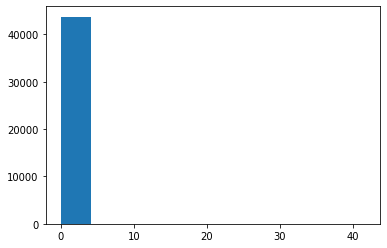

In [20]:
plt.hist(tree['rechit_energy'].array()[399])


(array([ 3736., 14755.,   217.,     0.,     0.,     0.,     0.,   182.,
        14528.,  3942.]),
 array([-3.516615 , -2.8142407, -2.1118665, -1.4094921, -0.7071179,
        -0.0047437,  0.6976305,  1.4000047,  2.102379 ,  2.8047533,
         3.5071275], dtype=float32),
 <BarContainer object of 10 artists>)

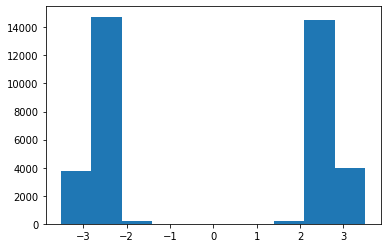

In [88]:
plt.hist(tree['rechit_eta'].array()[100])

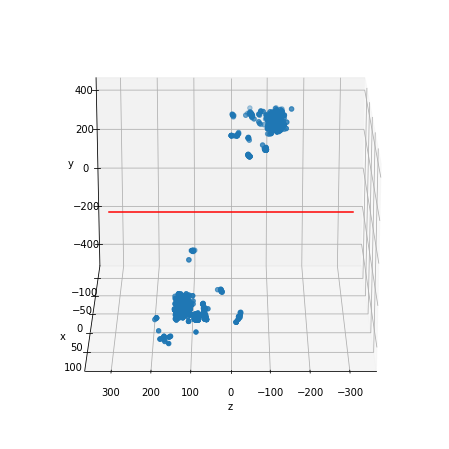

In [26]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111 , projection='3d')
ax.scatter(tree['simhit_x'].array()[1], tree['simhit_y'].array()[1], tree['simhit_z'].array()[1])
ax.plot([-320., 320.], [0,0], [0,0], color='r') # This is the beamline
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.view_init(20, 90)

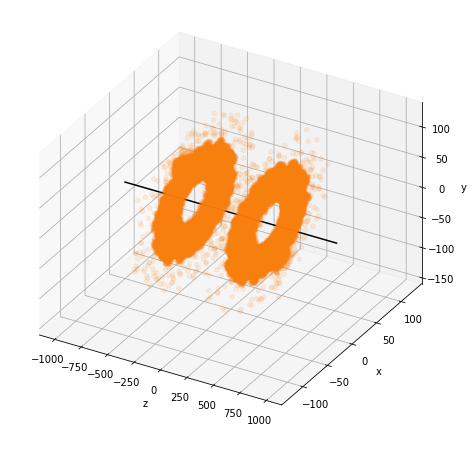

In [6]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111 , projection='3d')
ax.scatter(tree['rechit_z'].array()[0], 
           tree['rechit_x'].array()[0], 
           tree['rechit_y'].array()[0],
           color = "tab:orange",
           alpha = 0.1)
ax.plot([-1000., 1000.], [0,0], [0,0], color='k') # This is the beamline
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.set_proj_type('ortho')
#ax.view_init(0, 90)

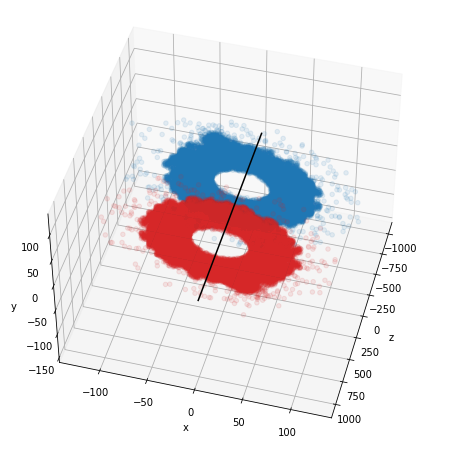

In [11]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111 , projection='3d')
mask = tree['rechit_z'].array()[0] < 0 
ax.scatter(tree['rechit_z'].array()[0][mask], 
           tree['rechit_x'].array()[0][mask], 
           tree['rechit_y'].array()[0][mask],
           alpha = 0.1,
          color='tab:blue')
mask = tree['rechit_z'].array()[0] > 0
ax.scatter(tree['rechit_z'].array()[0][mask], 
           tree['rechit_x'].array()[0][mask], 
           tree['rechit_y'].array()[0][mask],
           alpha = 0.1,
          color='tab:red')
ax.plot([-1000., 1000.], [0,0], [0,0], color='k',zorder = 100) 
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.view_init(45, 15)

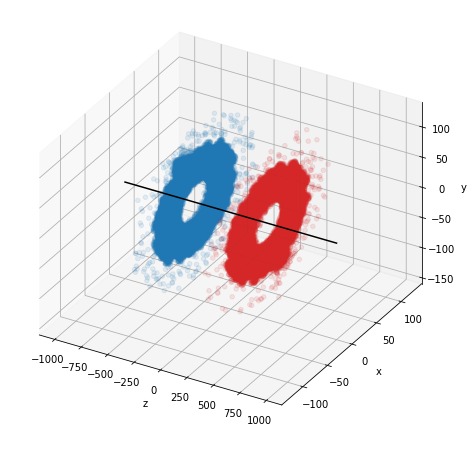

In [10]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111 , projection='3d')
mask = tree['rechit_z'].array()[0] < 0 
ax.scatter(tree['rechit_z'].array()[0][mask], 
           tree['rechit_x'].array()[0][mask], 
           tree['rechit_y'].array()[0][mask],
           alpha = 0.1,
          color='tab:blue')
mask = tree['rechit_z'].array()[0] > 0
ax.scatter(tree['rechit_z'].array()[0][mask], 
           tree['rechit_x'].array()[0][mask], 
           tree['rechit_y'].array()[0][mask],
           alpha = 0.1,
          color='tab:red')
ax.plot([-1000., 1000.], [0,0], [0,0], color='k', zorder = 100) 
ax.set_xlabel('z')
ax.set_ylabel('x')
ax.set_zlabel('y')
ax.set_proj_type('ortho')